In [4]:
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab10')
from corner import corner

from sklearn import datasets
import torch
from copy import deepcopy
from sbi.neural_nets.flow import build_nsf

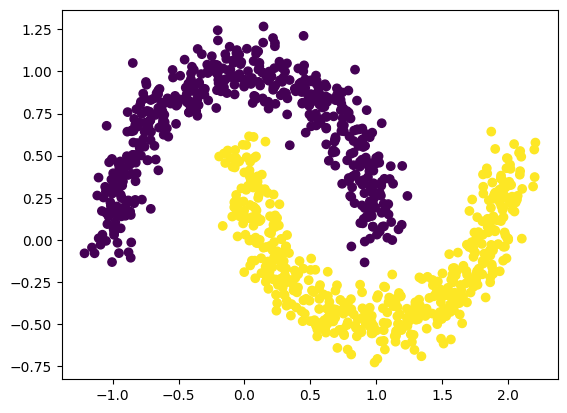

In [52]:
x, y = datasets.make_moons(1_000, noise=.1)
plt.scatter(*x.T, c=y);

In [67]:
torch.tensor(y[:, None])[:1].numel()

1

In [68]:
nsf = build_nsf(
    batch_x=torch.from_numpy(x.astype(np.float32)),
    batch_y=torch.from_numpy(y[:, None].astype(np.float32)),
    z_score_x=None, #'independent',
    z_score_y=None, #'independent',
    )

In [79]:
y[0][None, None].shape

(1, 1)

In [83]:
torch.tensor(y[0]).dtype

torch.int64

In [89]:
nsf.sample(1_000, torch.tensor(y[0][None, None], dtype=torch.float32))[0].detach().numpy()

array([[ 1.4222482 , -1.2991203 ],
       [-1.3715692 ,  0.47995293],
       [ 0.25816905, -1.0154399 ],
       ...,
       [-2.5547466 ,  1.1580199 ],
       [ 1.8715731 , -3.0261006 ],
       [-1.5843815 , -0.9178862 ]], dtype=float32)